# 北尾早霧・砂川武貴・山田知明『定量的マクロ経済学と数値計算』日本評論社
## 第2章：2期間モデルと数値計算の概観

## 2.5.2 射影法

### パラメータの設定はこれまでと同じ

In [5]:
class Models:
    def __init__(self,β:float,γ:float,rent:float,nw:int,w_max:float,w_min:float,grid_w:"np.ndarray[np.float64]"):
        # パラメータ
        self.β = β # 割引因子
        self.γ = γ # 相対的危険回避度

        # 要素価格
        self.rent = rent # 純利子率

        # グリッド
        self.nw = nw # 所得グリッドの数
        self.w_max = w_max # 所得グリッドの最大値
        self.w_min = w_min # 所得グリッドの最小値 
        self.grid_w = grid_w # 所得グリッド

In [6]:
def Calibration():
    # パラメータはここで設定をする
    β = 0.985**30
    γ = 2.0
    rent = 1.025**30 - 1.0
    nw = 10
    w_max = 1.0
    w_min = 0.1

    grid_w = np.linspace(w_min,w_max,nw)

    return Models(β, γ, rent, nw, w_max, w_min, grid_w)

---

In [7]:
# 使う関数を呼び出す
import numpy as np # 配列を扱うためのパッケージ
import matplotlib.pyplot as plt # プロットを行うためのパッケージ
!pip install japanize_matplotlib
import japanize_matplotlib # プロットで日本語を使うためのパッケージ
from scipy import optimize # Python上の Optimization Tool
import time # 計測時間をはかるためのパッケージ

---

In [8]:
params = Calibration()

In [9]:
def mu_CRRA(cons,γ):
    return cons**(-γ)

---

In [10]:
def approx_policy(coef,eval):
    """
    政策関数を多項式によって近似する

    # インプット
    `coef`: 多項式の係数
    `eval`:選点

    # アウトプット
    `next_a`:2期における資産水準
    """
    
    dim_app = len(coef)
    nw = len(eval)
    XX = np.zeros((nw, dim_app))

    for i in range(dim_app):
        XX[:,i] = eval ** i
    
    next_a = XX @ coef.T

    return next_a

In [11]:
def resid_projection(coef, params):
    """
    選点に基づいてオイラー方程式の残差を返す

    # インプット
    `coef`:多項式の係数
    `m::Models`:パラメータを含む構造体

    # アウトプット
    `residual::Vector`:残差
    """

    # 係数coefを使って政策関数を計算
    a = approx_policy(coef, params.grid_w)

    # 各wにおける1期の消費水準を計算
    c1 = params.grid_w - a

    # 2期の消費水準
    c2 = (1.0 + params.rent)*a

    ng = len(c1) # 次元を取り出す
    mu1 = np.zeros(ng) #1期における限界効用
    mu2 = np.zeros_like(mu1) #2期における限界効用
    resid = np.zeros_like(mu1) #残差

    for i in range(ng):
        
        if c1[i] > 0.0:
            mu1[i] = mu_CRRA(c1[i], params.γ)
        else:
            mu1[i] = 10000.0 #負の消費に対するペナルティ
        
        if c2[i] > 0.0:
            mu2[i] = mu_CRRA(c2[i], params.γ)
        else:
            mu2[i] = 10000.0 #負の消費に対するペナルティ
        
        resid[i] = params.β*(1.0 + params.rent)*(mu2[i]/mu1[i]) - 1.0
    

    return resid

In [12]:
def projection(params,coef_init = [0.1, 0.35]):
    """
    射影法によって2期間モデルを解く

    # インプット
    `m::Models`: パラメータを含む構造体
    `coef_init`:係数の初期予想

    # アウトプット
    `res.minimizer`:非線形最小二乗法によって得られた係数
    `res.converged`:最小二乗法が収束したかを示す変数
    `next_a`:射影法によって得られる政策関数
    """

    # 多項式の次元を決定
    resid_projection1 = lambda coef: resid_projection(coef, params)

    # レーベンバーグ・マルカート法で非線形最小二乗法を行う
    res = optimize.least_squares(resid_projection1,x0=coef_init,method="lm")

    # ゼロ点探索によって得た係数を使って政策関数を求める
    next_a = approx_policy(res.x, params.grid_w)

    return res.x, res.success , next_a


In [13]:
start = time.time() # 実行時間の計測開始
res = projection(params)
end = time.time() # 実行時間の計測終了
print(f"{end-start:.6f} seconds")

0.007993 seconds


---

## 計算結果を出力

In [14]:
# 解析解
# テキストの(2.4)式
coef1 = (params.β*(1.0+params.rent))**(-1.0/params.γ)
coef2 = 1.0/(1.0+coef1*(1.0+params.rent))
a_cfs = coef2*params.grid_w

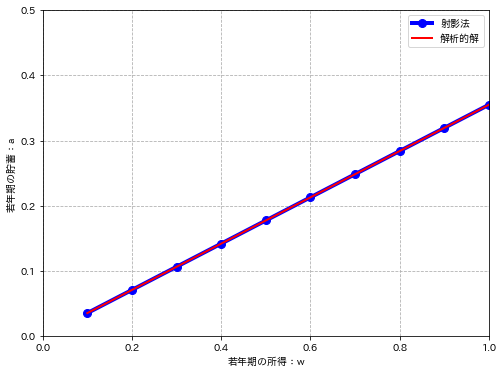

In [15]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(params.grid_w,res[2],c="b",marker="o",lw=4,ms=8,label="射影法")
ax.plot(params.grid_w,a_cfs,c="r",lw=2,label="解析的解")
ax.set(xlabel="若年期の所得：w",ylabel="若年期の貯蓄：a",xlim=(0,1.0),ylim=(0,0.5))
ax.legend(loc="upper right")
ax.grid(ls="--")
plt.show()

---

## エクササイズ
* グリッドの数を増やしてみよう
* 時限を増やしてみよう